In [108]:
import math, os
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product
from autograd.extend import primitive, defvjp
import meep as mp
import meep.adjoint as mpa
from meep.materials import Ag
import matplotlib.pyplot as plt
import nlopt

mp.verbosity(0)
resolution = 50      # px/µm

lambda0 = 0.5            # [um]
fcen    = 1.0 / lambda0  # [1/um]
width = 0.1
fwidth = fcen*width

nfreq   = 1
frequencies = [fcen]

dpml = 0.5
dair = 1.0
hrod = 0.5     

dsub = 1.0
dAg  = 0.25

sx = 2.121                          # +-3차가 +-45도 나옴
sx = 2.828                          # +-4차가 +-45도 나옴
sy = dpml + dair + hrod + dsub + dAg + dpml
cell_size = mp.Vector3(sx, sy)

wrod = sx

Medium1 = mp.Medium(index = 2.0)
Medium2 = mp.Medium(index = 1.0)

pml_layers = [
    mp.PML(direction=mp.Y, thickness=dpml, side=mp.High),
    mp.PML(direction=mp.Y, thickness=dpml, side=mp.Low),
    
]

@primitive
def layer_division_2d_autodiff(x_flat, num_layer, Nx, Ny):
    """
    x_flat: (Nx*Ny,) 1D 디자인 벡터
    y 방향으로 num_layer 개로 나누어, 각 레이어 내부를 y축 평균값으로 평탄화함.
    """
    X2 = x_flat.reshape(Nx, Ny)
    Xout = npa.zeros_like(X2)

    # 레이어 높이 계산 (픽셀 단위)
    # 균일하게 나누기 위해 linspace 사용 후 정수로 변환
    layer_boundaries = np.linspace(0, Ny, num_layer + 1).astype(int)

    for i in range(num_layer):
        s, e = layer_boundaries[i], layer_boundaries[i+1]
        if s == e: continue # 혹시라도 해상도가 너무 낮을 경우 대비

        # 해당 레이어 구간 추출 (Nx, thickness)
        seg = X2[:, s:e]
        
        # y축 방향 평균 계산 -> (Nx, 1)
        m = npa.mean(seg, axis=1, keepdims=True)

        # 평균값을 해당 레이어 전체에 브로드캐스팅
        Xout[:, s:e] = npa.broadcast_to(m, seg.shape)

    return Xout.reshape(-1)

def _ld2d_vjp(ans, x_flat, num_layer, Nx, Ny):
    """
    VJP: 레이어 평균화(Mean) 연산의 역전파
    Forward에서 평균을 취했으므로, Backward에서는 Gradient를 
    레이어 픽셀 수(n_elem)로 나누어 분배함.
    """
    def vjp(g_flat):
        g2 = g_flat.reshape(Nx, Ny)
        gout = npa.zeros_like(g2)

        layer_boundaries = np.linspace(0, Ny, num_layer + 1).astype(int)

        for i in range(num_layer):
            s, e = layer_boundaries[i], layer_boundaries[i+1]
            if s == e: continue

            gseg = g2[:, s:e]
            n_elem = float(e - s) # 레이어의 두께(픽셀 수)
            
            # 해당 레이어의 Gradient 합계 계산
            gsum = npa.sum(gseg, axis=1, keepdims=True)

            # Gradient를 입력 픽셀들에 균등 분배
            gout[:, s:e] = npa.broadcast_to(gsum / n_elem, gseg.shape)

        return gout.reshape(-1)

    return vjp

# VJP 등록
defvjp(
    layer_division_2d_autodiff,
    lambda ans, x, num, nx, ny: _ld2d_vjp(ans, x, num, nx, ny),
    argnums=[0] # x_flat에 대해서만 미분
)

DESIGN_W  = wrod
DESIGN_H  = hrod
design_c  = mp.Vector3(0, 0.5*sy - dpml - dAg - dsub - 0.5*hrod)
design_sz = mp.Vector3(DESIGN_W, DESIGN_H)


design_res = resolution
NX = int(DESIGN_W * design_res) + 1

DESIGN_MODE = 'free'  # or 'free' or 'grating'

if DESIGN_MODE == 'free':
    NY = int(round(DESIGN_H * design_res)) + 1
else:
    # 해상도와 레이어-패딩 조건을 동시에 만족
    DESIRED_LAYERS = 3       # 원하는 레이어 수 (패딩 1픽셀씩 자동)
    NY_min_layers = 2 * DESIRED_LAYERS - 1        # 레이어 L개 + 패딩 L-1개
    NY_res       = int(round(DESIGN_H * design_res))
    NY = max(NY_res, NY_min_layers)

n_vars = NX * NY

# 최소 피쳐/이진화 설정
MIN_FEATURE = 0.09    # ~80 nm
eta_i = 0.55
filter_radius = mpa.get_conic_radius_from_eta_e(MIN_FEATURE, eta_i)

# x = np.ones((n_vars,), dtype=float) * 0.5
np.random.seed(42)

x = np.random.rand(n_vars) * 0.2 + 0.4
# x = np.ones(n_vars)*0.5

design_vars = mp.MaterialGrid(
    mp.Vector3(NX, NY, 0),
    Medium1, Medium2,
    grid_type="U_MEAN",
)
design_region = mpa.DesignRegion(design_vars, volume=mp.Volume(center=design_c, size=design_sz))

# ----------------------------
# geometry (디자인 포함)
# ----------------------------
geometry = [
    mp.Block(
        material=Ag,
        center=mp.Vector3(0, 0.5*sy - dpml - 0.5*dAg),
        size=mp.Vector3(mp.inf, dAg, mp.inf),
    ),
    # Medium1 bulk (Ag 아래에 위치)
    mp.Block(
        material=Medium1,
        center=mp.Vector3(0, 0.5*sy - dpml - dAg - 0.5*dsub),
        size=mp.Vector3(mp.inf, dsub, mp.inf),
    ),
    # Design block (텍스처 영역)
    mp.Block(
        material=design_vars,
        center=design_region.center,
        size=design_region.size,
    ),
]

bottom_pml_top_y = -0.5 * sy + dpml
src_center = mp.Vector3(0, bottom_pml_top_y + (3 / resolution))
src_size   = mp.Vector3(sx, 0, 0)

# sources = [
#     mp.Source(
#         mp.GaussianSource(frequency=fcen, fwidth=fwidth),
#         component=mp.Ez,
#         center=mp.Vector3(0, src_center.y),
#         size=mp.Vector3(sx, 0)
#     )
# ]



import cmath
import math

# ------------------------------------------------------------
# -4, 0, +4 회절차수 성분을 동시에 갖는 라인 소스 생성
# 목표 파워비: [m=-4, m=0, m=+4] = [0.2, 0.6, 0.2]
# ------------------------------------------------------------
def make_three_order_amp_func(sx, fcen, n_src, m_order, P0=0.6, Pp=0.2):
    """
    sx      : 주기 길이 [um]
    fcen    : 주파수 [1/um]
    n_src   : 소스가 놓인 매질 굴절률 (여기서는 공기면 1.0)
    m_order : 여기서는 4 (±4차)
    P0      : 0차 파워 비율
    Pp      : +m, -m 각각의 파워 비율 (대칭)

    반환: mp.Source의 amp_func로 넣을 함수
    """
    # k0 = 2π f n (rad/um)
    k0 = 2.0 * math.pi * fcen * n_src

    # kx(m) = 2π m / sx  (rad/um)  --- (m은 정수면 주기 경계에서 정확히 맞음)
    kx_p = 2.0 * math.pi * m_order / sx
    kx_0 = 0.0

    # ky = sqrt(k0^2 - kx^2) (rad/um)  --- 전파 가능한지 체크
    ky_0 = math.sqrt(max(k0 * k0 - kx_0 * kx_0, 0.0))
    ky_p = math.sqrt(max(k0 * k0 - kx_p * kx_p, 0.0))

    # 전파 불가(ky=0)면 파워 분배가 의미 없으므로 여기서 바로 막는다.
    # (현재 파라미터 sx=2.828, lambda0=0.5, m=4면 ky_p>0 이라 통과)
    if ky_0 <= 0.0 or ky_p <= 0.0:
        raise ValueError("선택한 m_order가 전파 불가능합니다(ky<=0). sx/lambda0/n_src를 확인하세요.")

    # 파워 ~ ky * |A|^2  =>  |A| = sqrt(P/ky)
    A0 = math.sqrt(P0 / ky_0)
    Ap = math.sqrt(Pp / ky_p)

    # 위상은 0으로 두고 대칭 성분으로 구성
    # a(x) = A0 + Ap*exp(+i kx x) + Ap*exp(-i kx x)
    def amp_func(r):
        x = r.x
        return (A0
                + Ap * cmath.exp(1j * kx_p * x)
                + Ap * cmath.exp(-1j * kx_p * x))

    return amp_func


# ------------------------------------------------------------
# 기존 sources를 아래처럼 교체
# ------------------------------------------------------------
n_src = 1.0     # 소스가 있는 아래쪽은 공기라서 1.0 (네 구조 정의 기준)
m_order = 4     # ±4차

amp_func_3orders = make_three_order_amp_func(
    sx=sx,
    fcen=fcen,
    n_src=n_src,
    m_order=m_order,
    P0=0.6,
    Pp=0.2
)

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=fwidth),
        component=mp.Ez,
        center=mp.Vector3(0, src_center.y),
        size=mp.Vector3(sx, 0, 0),
        amp_func=amp_func_3orders,   # <-- 핵심: x 방향 위상/진폭을 부여
    )
]





##### 공정 가능한 구조 설계시 #####
def grating_mapping(x, eta, beta):
    global DESIRED_LAYERS

    X = layer_division_2d_autodiff(
            x.ravel(), DESIRED_LAYERS, NX, NY
    )    
    X_2D = X.reshape(NX,NY)
    X_symmetry = 0.5 * (npa.flipud(X_2D) + X_2D)                 # <- 좌우 대칭
    X_projection = mpa.tanh_projection(X_2D, beta=beta, eta=eta)
    return X_projection.ravel()


##### 완전한 자유형상 설계시 #####
def free_mapping(x, eta, beta):
    filt = mpa.conic_filter(x, filter_radius, DESIGN_W, DESIGN_H, design_res)   # (NY, NX)
    filt = (npa.flipud(filt) + filt) / 2
    projected_field = mpa.tanh_projection(filt, beta, eta)

    return projected_field.flatten()

##### Mode 선택 #####
mapping = free_mapping if DESIGN_MODE == 'free' else grating_mapping

sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    k_point = mp.Vector3(0,0,0),
    extra_materials=[Ag],
    default_material=mp.Medium(index=1),
)
# --- FourierFields 모니터 (y=0.7 선) ---
ff_center = mp.Vector3(0, 0.7, 0)
ff_size   = mp.Vector3(sx, 0, 0)
ff_vol    = mp.Volume(center=ff_center, size=ff_size)

ff_Ez = mpa.FourierFields(sim, volume=ff_vol, component=mp.Ez)
# -----------------------------------------
# 1) DFT 모니터 설치 (ff_Ez와 동일한 위치/길이)
# -----------------------------------------
dft_line = sim.add_dft_fields([mp.Ez], fcen, 0, 1, center=ff_center, size=ff_size)


In [109]:
import cmath
import math
import numpy as np

def make_three_order_amp_func_intensity(sx, m_order, A0, Ap, phi_p=0.0):
    """
    목표 정의: 모니터에서의 |FFT(Ez)|^2 비율을 맞추기 위해
    소스 전류 분포를 0, ±m 고조파로 구성.

    a(x) = A0 + Ap*exp(i(kx x + phi)) + Ap*exp(-i(kx x + phi))
         = A0 + 2*Ap*cos(kx x + phi)

    sx: 주기 길이 [um]
    m_order: 예) 4
    A0: 0차 계수(실수 양수 권장)
    Ap: ±m차 계수(실수 양수 권장)
    phi_p: ±m차 공통 위상(라디안)
    """
    kx_p = 2.0 * math.pi * m_order / sx  # rad/um (주기 sx에서 정수 m이면 정확히 주기적)

    def amp_func(r):
        x = r.x
        return (A0
                + Ap * cmath.exp(1j * (kx_p * x + phi_p))
                + Ap * cmath.exp(-1j * (kx_p * x + phi_p)))

    return amp_func

def measure_ratio_intensity_from_dft(sim, dft_line, resolution, target_m=4):
    """
    sim.get_dft_array로 Ez_line을 가져와서 FFT한 뒤,
    m=0, ±target_m bin의 |FFT|^2 비율을 반환.

    반환: (rm4, r0, rp4, Im4, I0, Ip4)
    """
    Ez_line = np.squeeze(np.array(sim.get_dft_array(dft_line, mp.Ez, 0))).ravel()

    fft_Ez = np.fft.fftshift(np.fft.fft(Ez_line))
    kx = np.fft.fftshift(np.fft.fftfreq(len(fft_Ez), d=1 / resolution))  # 네 기존 방식 유지

    i0 = int(np.argmin(np.abs(kx)))
    idx_m = target_m

    idx_m4 = i0 - idx_m
    idx_0  = i0
    idx_p4 = i0 + idx_m

    # intensity = |FFT|^2
    Im4 = np.abs(fft_Ez[idx_m4])**2
    I0  = np.abs(fft_Ez[idx_0 ])**2
    Ip4 = np.abs(fft_Ez[idx_p4])**2

    It = Im4 + I0 + Ip4
    rm4, r0, rp4 = Im4 / It, I0 / It, Ip4 / It

    return rm4, r0, rp4, Im4, I0, Ip4

def calibrate_three_order_source_to_target(
    sim,
    src_center_y,
    fcen,
    fwidth,
    sx,
    resolution,
    dft_center,
    dft_size,
    m_order=4,
    Tm4=0.2,
    T0=0.6,
    Tp4=0.2,
    n_iter=8,
    tol=1e-3,
    run_decay_time=200,
    decay_thresh=1e-6,
):
    """
    구조/모니터 위치를 '그대로' 둔 채로,
    소스(amp_func) 계수 A0, Ap를 반복 보정해서
    DFT 라인에서의 |FFT(Ez)|^2 비율이 목표에 맞도록 만든다.

    sim: 이미 geometry/bc/material 설정된 Simulation 객체
    src_center_y: 소스 y 위치 (기존 src_center.y)
    dft_center, dft_size: dft_line 설치 파라미터
    n_iter: 보정 반복 횟수
    tol: 비율 L2 오차 기준 종료
    """

    # 초기값: "비율 정의가 |FFT|^2" 이므로 amplitude는 sqrt(target)로 시작
    A0 = math.sqrt(T0)
    Ap = math.sqrt(Tp4)

    for it in range(n_iter):
        # --- 소스 amp_func 갱신 ---
        amp_func = make_three_order_amp_func_intensity(sx, m_order, A0=A0, Ap=Ap, phi_p=0.0)
        new_sources = [
            mp.Source(
                mp.GaussianSource(frequency=fcen, fwidth=fwidth),
                component=mp.Ez,
                center=mp.Vector3(0, src_center_y, 0),
                size=mp.Vector3(sx, 0, 0),
                amp_func=amp_func,
            )
        ]

        # --- 시뮬레이션 리셋 후 소스/DFT 재설치 ---
        sim.reset_meep()
        sim.change_sources(new_sources)
        dft_line = sim.add_dft_fields([mp.Ez], fcen, 0, 1, center=dft_center, size=dft_size)

        # --- 실행: 소스가 꺼진 뒤 필드 감쇠까지 ---
        sim.run(
            until_after_sources=mp.stop_when_fields_decayed(
                run_decay_time, mp.Ez, dft_center, decay_thresh
            )
        )

        # --- 비율 측정 ---
        rm4, r0, rp4, Im4, I0, Ip4 = measure_ratio_intensity_from_dft(
            sim, dft_line, resolution, target_m=m_order
        )

        # --- 오차 계산 및 출력 ---
        err = (rm4 - Tm4) ** 2 + (r0 - T0) ** 2 + (rp4 - Tp4) ** 2
        print(f"[calib {it+1}/{n_iter}] ratio = ({rm4:.6f}, {r0:.6f}, {rp4:.6f}), err={err:.3e}, A0={A0:.4g}, Ap={Ap:.4g}")

        if err < tol:
            break

        # --- 계수 보정(비례 업데이트) ---
        # 0으로 나누기 방지
        r0_safe  = max(float(r0),  1e-12)
        rp4_safe = max(float(rp4), 1e-12)

        # 목표/측정 비율에 따라 amplitude를 sqrt 비율로 스케일
        A0 = A0 * math.sqrt(T0  / r0_safe)
        Ap = Ap * math.sqrt(Tp4 / rp4_safe)

    # 최종 amp_func 반환
    final_amp_func = make_three_order_amp_func_intensity(sx, m_order, A0=A0, Ap=Ap, phi_p=0.0)
    return final_amp_func, (A0, Ap)


# (1) 먼저 sim을 만든 다음(네 코드 그대로) 보정 실행
final_amp_func, (A0_final, Ap_final) = calibrate_three_order_source_to_target(
    sim=sim,
    src_center_y=src_center.y,
    fcen=fcen,
    fwidth=fwidth,
    sx=sx,
    resolution=resolution,
    dft_center=ff_center,         # 네 DFT 라인 센터
    dft_size=ff_size,             # 네 DFT 라인 크기
    m_order=4,
    Tm4=0.2, T0=0.6, Tp4=0.2,
    n_iter=8,
    tol=1e-4,
)

print("Final source coeffs:", A0_final, Ap_final)

# (2) 최종 sources를 이 amp_func로 고정
sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=fwidth),
        component=mp.Ez,
        center=mp.Vector3(0, src_center.y, 0),
        size=mp.Vector3(sx, 0, 0),
        amp_func=final_amp_func,
    )
]

# (3) sim에 소스 반영
sim.change_sources(sources)


[calib 1/8] ratio = (0.372366, 0.255267, 0.372366), err=1.783e-01, A0=0.7746, Ap=0.4472


[calib 2/8] ratio = (0.205055, 0.589889, 0.205055), err=1.533e-04, A0=1.188, Ap=0.3278
[calib 3/8] ratio = (0.200096, 0.599807, 0.200096), err=5.567e-08, A0=1.198, Ap=0.3237
Final source coeffs: 1.1976888217839123 0.32368626071699313


FloatProgress(value=400.010009765625, description='0% done ', max=401.010009765625, min=400.010009765625)

<Axes: xlabel='X', ylabel='Y'>

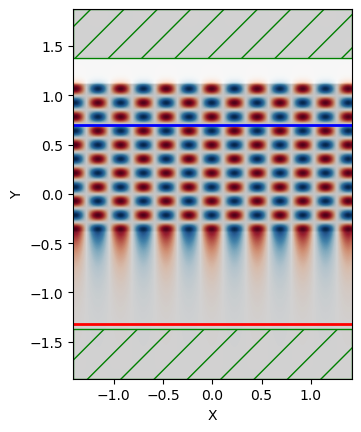

In [110]:
sim.run(until = 1)
sim.plot2D(fields = mp.Ez)

In [107]:
Ez_line = np.squeeze(np.array(sim.get_dft_array(dft_line, mp.Ez, 0))).ravel()  # 1D 보장
fft_Ez  = np.fft.fftshift(np.fft.fft(Ez_line))
kx      = np.fft.fftshift(np.fft.fftfreq(len(fft_Ez), d=1/resolution))

# 0 bin 인덱스
i0 = int(np.argmin(np.abs(kx)))

# -4, 0, +4 bin 인덱스
idx_m4 = i0 - 4
idx_0  = i0
idx_p4 = i0 + 4

# intensity 정의: |FFT|^2
Im4 = np.abs(fft_Ez[idx_m4])**2
I0  = np.abs(fft_Ez[idx_0])**2
Ip4 = np.abs(fft_Ez[idx_p4])**2

Itot = Im4 + I0 + Ip4

# 0 나누기 방지
if Itot == 0:
    raise ValueError("Itot=0 입니다. FFT가 전부 0인지(모니터/소스/DFT 설정) 확인하세요.")

rm4 = Im4 / Itot
r0  = I0  / Itot
rp4 = Ip4 / Itot

# 목표 비율
T_m4, T_0, T_p4 = 0.2, 0.6, 0.2

print("\n===== Target mode power ratio (using |FFT|^2) =====")
print(f"m=-4: {rm4:.6f} (target {T_m4})")
print(f"m= 0: {r0 :.6f} (target {T_0 })")
print(f"m=+4: {rp4:.6f} (target {T_p4})")

# 오차도 같이 출력(L2)
err = (rm4 - T_m4)**2 + (r0 - T_0)**2 + (rp4 - T_p4)**2
print(f"L2 error = {err:.6e}")

# 참고: %로도 출력
print("\n===== Percentage =====")
print(f"m=-4: {100*rm4:.2f}%")
print(f"m= 0: {100*r0 :.2f}%")
print(f"m=+4: {100*rp4:.2f}%")


===== Target mode power ratio (using |FFT|^2) =====
m=-4: 0.401278 (target 0.2)
m= 0: 0.197443 (target 0.6)
m=+4: 0.401278 (target 0.2)
L2 error = 2.430777e-01

===== Percentage =====
m=-4: 40.13%
m= 0: 19.74%
m=+4: 40.13%


m=-4,0,+4 intensity ratios = [0.2 0.6 0.2]
should be [0.2, 0.6, 0.2]


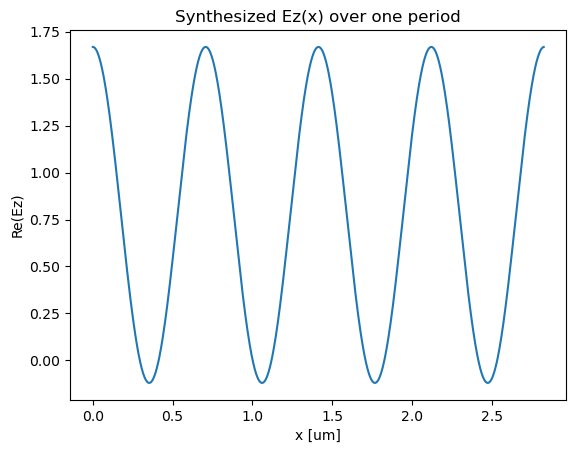

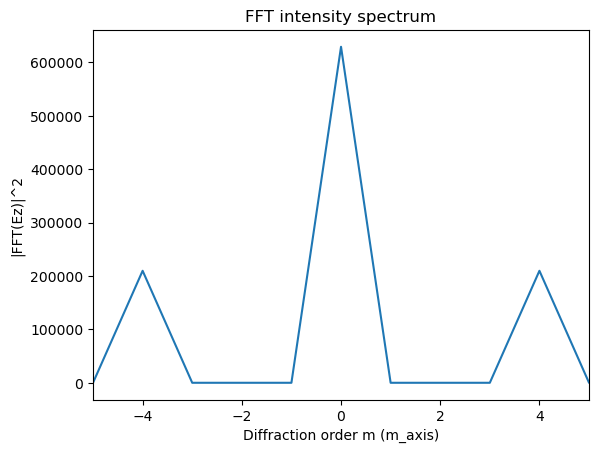

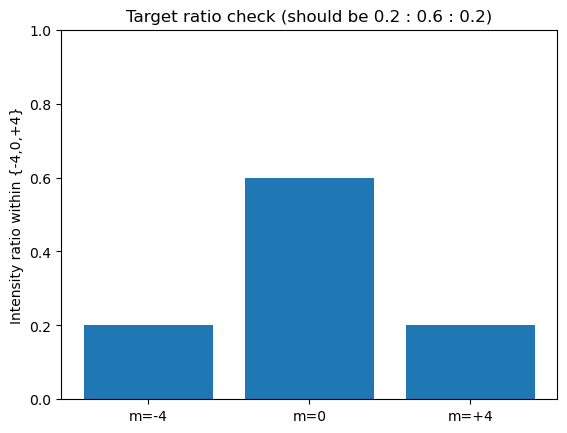

In [114]:
import numpy as np
import math
import matplotlib.pyplot as plt

# -----------------------------
# 파라미터 (네 설정과 동일하게 맞춤)
# -----------------------------
sx = 2.828          # [um] 주기
m_order = 4         # 목표 모드: -4, 0, +4
N = 1024            # 샘플 수 (충분히 크게)

# -----------------------------
# (1) 목표 intensity 비율을 만족하는 푸리에 계수 정의
#     목표: |C_-4|^2 : |C_0|^2 : |C_+4|^2 = 0.2 : 0.6 : 0.2
# -----------------------------
C0 = math.sqrt(0.6)         # C_0
Cp = math.sqrt(0.2)         # C_+4
Cm = math.sqrt(0.2)         # C_-4  (대칭)

# -----------------------------
# (2) 한 주기 [0, sx)에서 파형 Ez(x) 합성
#     endpoint=False로 해야 주기 끝점 중복이 생기지 않음(FFT에 중요)
# -----------------------------
x = np.linspace(0.0, sx, N, endpoint=False)

# 복소 지수 합성(실수 파형이 되도록 +m, -m을 대칭으로 넣음)
Ez = (C0
      + Cp * np.exp(1j * 2.0 * np.pi * m_order * x / sx)
      + Cm * np.exp(-1j * 2.0 * np.pi * m_order * x / sx))

# -----------------------------
# (3) FFT 및 intensity 계산
#     FFT 정규화(/N)는 비율에는 영향 없음. (원하면 /N 넣어도 됨)
# -----------------------------
F = np.fft.fftshift(np.fft.fft(Ez))
I = np.abs(F) ** 2  # intensity = |FFT|^2

# FFT 축을 "회절차수 m_axis"로 변환:
# fftfreq는 cycles/um, m_axis = kx_cyc * sx  (이상적으로 정수에 정렬)
dx = sx / N
kx_cyc = np.fft.fftshift(np.fft.fftfreq(N, d=dx))   # cycles/um
m_axis = kx_cyc * sx                                # order axis

# -----------------------------
# (4) m=-4,0,+4 bin 인덱스 찾기(정확)
# -----------------------------
idx_m4 = int(np.argmin(np.abs(m_axis + m_order)))
idx_0  = int(np.argmin(np.abs(m_axis - 0.0)))
idx_p4 = int(np.argmin(np.abs(m_axis - m_order)))

Im4 = I[idx_m4]
I0  = I[idx_0]
Ip4 = I[idx_p4]

ratios = np.array([Im4, I0, Ip4]) / (Im4 + I0 + Ip4)

print("m=-4,0,+4 intensity ratios =", ratios)
print("should be [0.2, 0.6, 0.2]")

# -----------------------------
# (5) Plot: (a) Ez(x) (실수부), (b) FFT intensity 스펙트럼, (c) 세 모드 비율
# -----------------------------
plt.figure()
plt.plot(x, np.real(Ez))
plt.xlabel("x [um]")
plt.ylabel("Re(Ez)")
plt.title("Synthesized Ez(x) over one period")
plt.show()

plt.figure()
plt.plot(m_axis, I)
plt.xlabel("Diffraction order m (m_axis)")
plt.ylabel("|FFT(Ez)|^2")
plt.title("FFT intensity spectrum")
plt.xlim(-5,5)
plt.show()

plt.figure()
plt.bar(["m=-4", "m=0", "m=+4"], ratios)
plt.ylim(0, 1)
plt.ylabel("Intensity ratio within {-4,0,+4}")
plt.title("Target ratio check (should be 0.2 : 0.6 : 0.2)")
plt.show()


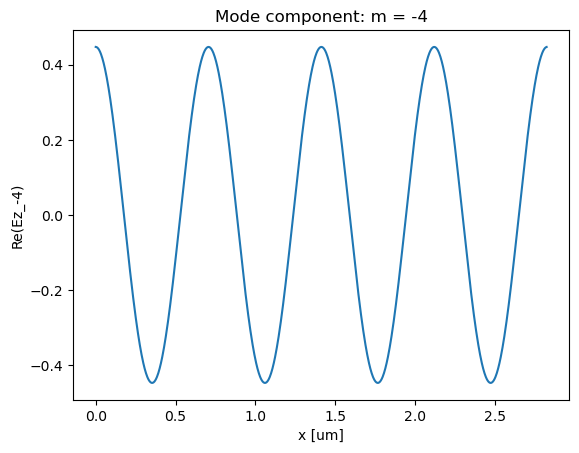

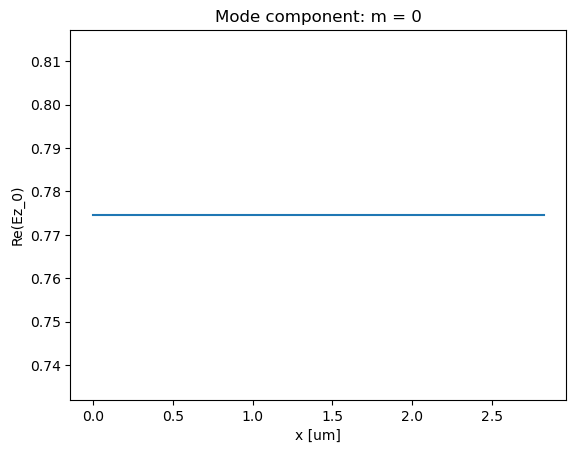

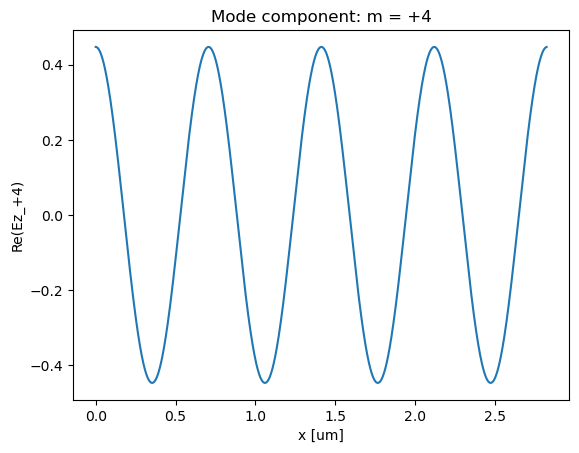

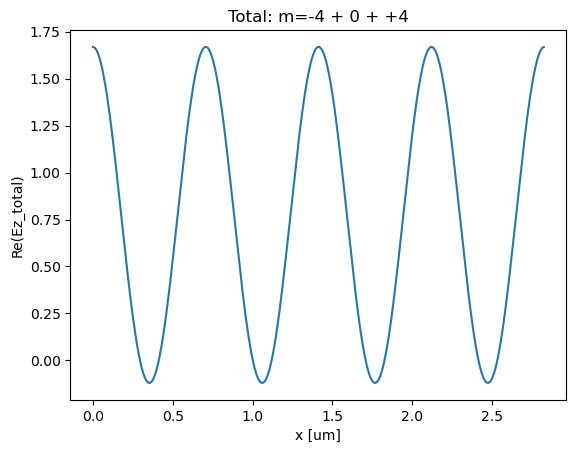

In [118]:
import numpy as np
import math
import matplotlib.pyplot as plt

# -----------------------------
# 기존과 동일 파라미터/계수 (예시)
# -----------------------------
sx = 2.828
m_order = 4
N = 1024

C0 = math.sqrt(0.6)
Cp = math.sqrt(0.2)
Cm = math.sqrt(0.2)

x = np.linspace(0.0, sx, N, endpoint=False)

# -----------------------------
# 각 모드 성분만 따로 합성
# -----------------------------
Ez_m4 = Cm * np.exp(-1j * 2.0 * np.pi * m_order * x / sx)  # m=-4
Ez_0  = C0 * np.ones_like(x, dtype=np.complex128)          # m=0
Ez_p4 = Cp * np.exp( 1j * 2.0 * np.pi * m_order * x / sx)  # m=+4

# (참고) 합치면 원래 파형
Ez_total = Ez_m4 + Ez_0 + Ez_p4

# -----------------------------
# 3개 플롯: -4차, 0차, +4차
# (실수부를 그리면 위상에 따라 cos 형태로 보임)
# -----------------------------
plt.figure()
plt.plot(x, np.real(Ez_m4))
plt.xlabel("x [um]")
plt.ylabel("Re(Ez_-4)")
plt.title("Mode component: m = -4")
plt.show()

plt.figure()
plt.plot(x, np.real(Ez_0))
plt.xlabel("x [um]")
plt.ylabel("Re(Ez_0)")
plt.title("Mode component: m = 0")
plt.show()

plt.figure()
plt.plot(x, np.real(Ez_p4))
plt.xlabel("x [um]")
plt.ylabel("Re(Ez_+4)")
plt.title("Mode component: m = +4")
plt.show()

# 원하면 총합도 같이 확인
plt.figure()
plt.plot(x, np.real(Ez_total))
plt.xlabel("x [um]")
plt.ylabel("Re(Ez_total)")
plt.title("Total: m=-4 + 0 + +4")
plt.show()


m=-4,0,+4 intensity ratios = [0.2 0.6 0.2]
should be [0.2, 0.6, 0.2]


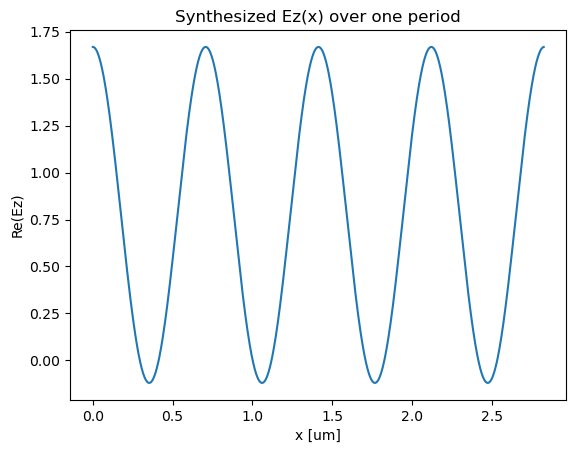

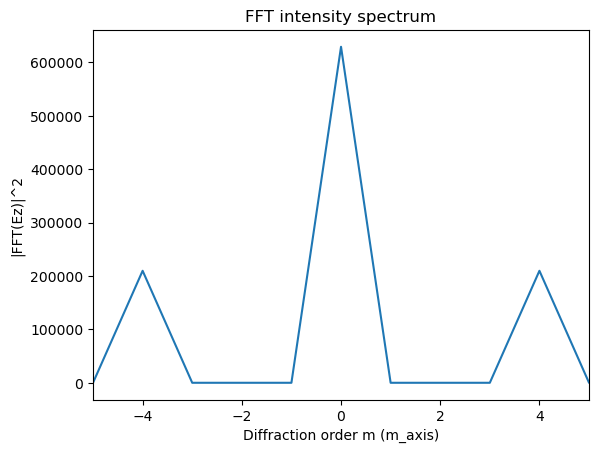

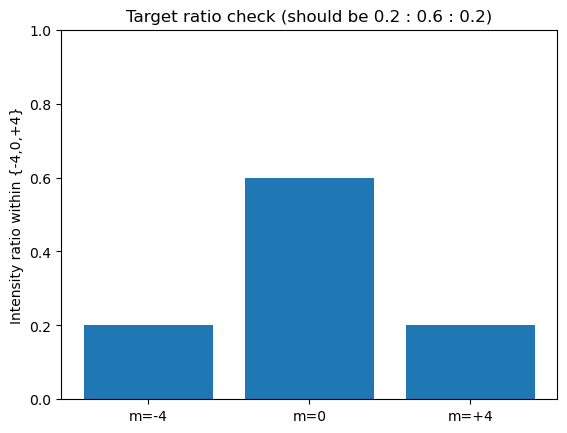

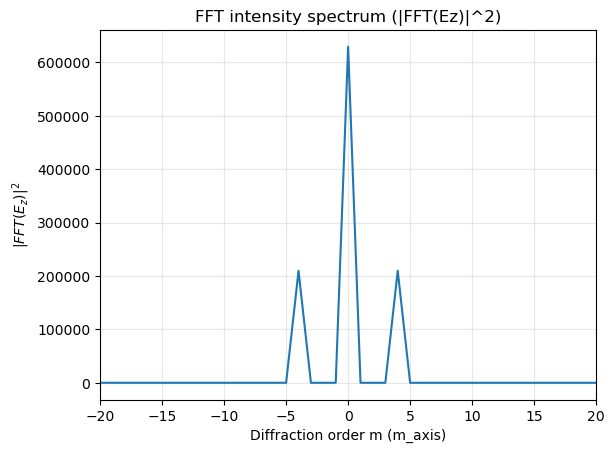

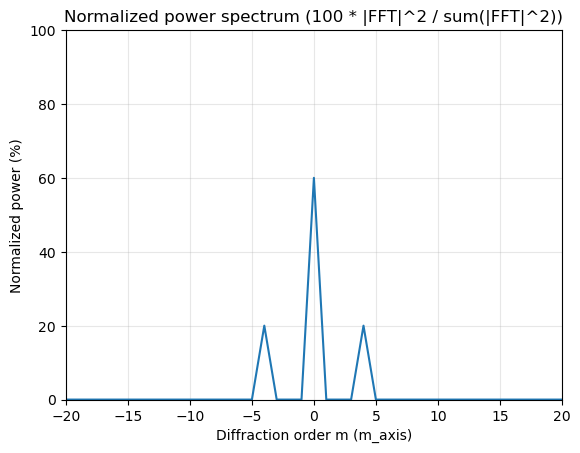

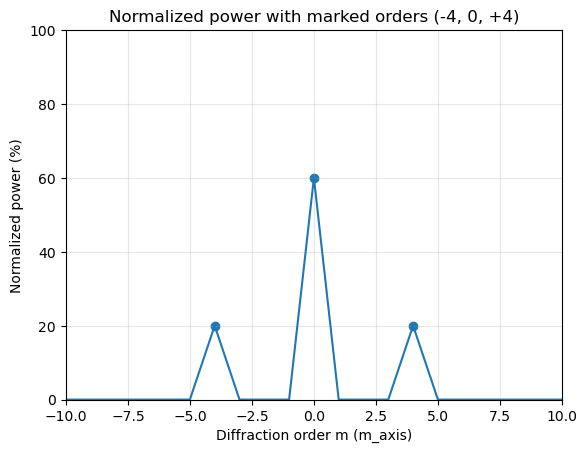

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

# -----------------------------
# 파라미터 (네 설정과 동일하게 맞춤)
# -----------------------------
sx = 2.828          # [um] 주기
m_order = 4         # 목표 모드: -4, 0, +4
N = 1024            # 샘플 수 (충분히 크게)

# -----------------------------
# (1) 목표 intensity 비율을 만족하는 푸리에 계수 정의
#     목표: |C_-4|^2 : |C_0|^2 : |C_+4|^2 = 0.2 : 0.6 : 0.2
# -----------------------------
C0 = math.sqrt(0.6)         # C_0
Cp = math.sqrt(0.2)         # C_+4
Cm = math.sqrt(0.2)         # C_-4  (대칭)

# -----------------------------
# (2) 한 주기 [0, sx)에서 파형 Ez(x) 합성
#     endpoint=False로 해야 주기 끝점 중복이 생기지 않음(FFT에 중요)
# -----------------------------
x = np.linspace(0.0, sx, N, endpoint=False)

# 복소 지수 합성(실수 파형이 되도록 +m, -m을 대칭으로 넣음)
Ez = (C0
      + Cp * np.exp(1j * 2.0 * np.pi * m_order * x / sx)
      + Cm * np.exp(-1j * 2.0 * np.pi * m_order * x / sx))

# -----------------------------
# (3) FFT 및 intensity 계산
#     FFT 정규화(/N)는 비율에는 영향 없음. (원하면 /N 넣어도 됨)
# -----------------------------
F = np.fft.fftshift(np.fft.fft(Ez))
I = np.abs(F) ** 2  # intensity = |FFT|^2

# FFT 축을 "회절차수 m_axis"로 변환:
# fftfreq는 cycles/um, m_axis = kx_cyc * sx  (이상적으로 정수에 정렬)
dx = sx / N
kx_cyc = np.fft.fftshift(np.fft.fftfreq(N, d=dx))   # cycles/um
m_axis = kx_cyc * sx                                # order axis

# -----------------------------
# (4) m=-4,0,+4 bin 인덱스 찾기(정확)
# -----------------------------
idx_m4 = int(np.argmin(np.abs(m_axis + m_order)))
idx_0  = int(np.argmin(np.abs(m_axis - 0.0)))
idx_p4 = int(np.argmin(np.abs(m_axis - m_order)))

Im4 = I[idx_m4]
I0  = I[idx_0]
Ip4 = I[idx_p4]

ratios = np.array([Im4, I0, Ip4]) / (Im4 + I0 + Ip4)

print("m=-4,0,+4 intensity ratios =", ratios)
print("should be [0.2, 0.6, 0.2]")

# -----------------------------
# (5) Plot: (a) Ez(x) (실수부), (b) FFT intensity 스펙트럼, (c) 세 모드 비율
# -----------------------------
plt.figure()
plt.plot(x, np.real(Ez))
plt.xlabel("x [um]")
plt.ylabel("Re(Ez)")
plt.title("Synthesized Ez(x) over one period")
plt.show()

plt.figure()
plt.plot(m_axis, I)
plt.xlabel("Diffraction order m (m_axis)")
plt.ylabel("|FFT(Ez)|^2")
plt.title("FFT intensity spectrum")
plt.xlim(-5,5)
plt.show()

plt.figure()
plt.bar(["m=-4", "m=0", "m=+4"], ratios)
plt.ylim(0, 1)
plt.ylabel("Intensity ratio within {-4,0,+4}")
plt.title("Target ratio check (should be 0.2 : 0.6 : 0.2)")
plt.show()

# -----------------------------
# (6) 합성된 파형 Ez의 FFT intensity와 정규화된 파워(%) 추가 플롯
# -----------------------------

# intensity (이미 I로 계산됨): I = |FFT(Ez)|^2
I_intensity = I.copy()

# 정규화된 파워(%) (전체 스펙트럼 대비)
total_I = np.sum(I_intensity)
if total_I == 0:
    raise ValueError("FFT intensity 총합이 0입니다. Ez가 모두 0인지 확인하세요.")

P_norm_percent = (I_intensity / total_I) * 100.0  # [%]

# (6-1) FFT intensity 플롯 (로그 스케일 옵션도 함께 제공)
plt.figure()
plt.plot(m_axis, I_intensity)
plt.xlabel("Diffraction order m (m_axis)")
plt.ylabel(r"$|FFT(E_z)|^2$")
plt.title("FFT intensity spectrum (|FFT(Ez)|^2)")
plt.xlim(-20, 20)
plt.grid(True, alpha=0.3)
plt.show()

# (6-2) 정규화된 파워(%) 플롯
plt.figure()
plt.plot(m_axis, P_norm_percent)
plt.xlabel("Diffraction order m (m_axis)")
plt.ylabel("Normalized power (%)")
plt.title("Normalized power spectrum (100 * |FFT|^2 / sum(|FFT|^2))")
plt.xlim(-20, 20)
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.show()

# (선택) -4, 0, +4 위치에 해당하는 점을 강조 표시하고 싶으면 아래 추가
plt.figure()
plt.plot(m_axis, P_norm_percent)
plt.scatter([m_axis[idx_m4], m_axis[idx_0], m_axis[idx_p4]],
            [P_norm_percent[idx_m4], P_norm_percent[idx_0], P_norm_percent[idx_p4]])
plt.xlabel("Diffraction order m (m_axis)")
plt.ylabel("Normalized power (%)")
plt.title("Normalized power with marked orders (-4, 0, +4)")
plt.xlim(-10, 10)
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.show()
